# Housing Prices Model

### Graeme Keleher 20190722

<p><a name="sections"></a></p>

## Sections

* [Load Packages](#1)
* [Import Data](#2)
* [Transform Target Variable](#3)
* [Seperate into Numeric and Categorical Features](#4)
* [Deal with Missing Categorical Data](#5)
* [Deal with Missing Numeric Data](#6)
* [Combine Feature Types, Dummify and Split](#7)
* [Baseline RandomForest Model](#8)


## Load Packages <a id="1"></a>

In [19]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
#from sklearn.model_selection import RepeatedKFold
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import RandomizedSearchCV
from xgboost import plot_importance

## Import Data <a id="2"></a>

Import training and test data from their respective files. 

In [20]:
#Load training data
X_train = pd.read_csv('train.csv', index_col = 'Id')

#load training data
X_test = pd.read_csv('test.csv', index_col = 'Id')


## Drop Outliers <a id="20"></a>

Drop outliers from training data then combine with test for processing

In [21]:
X_train = X_train.drop(X_train[(X_train['GrLivArea']>4000) & (X_train['SalePrice']<300000)].index)

#set target feature to y
y = X_train['SalePrice']

# drop target feature from training data
X_train.drop('SalePrice',axis=1,inplace=True)

#store end of training data index for future splitting
end_train_index = X_train.shape[0]

#Combine test and training predictive features for preprocessing
X = pd.concat([X_train,X_test])

## Transform Target Variable <a id="3"></a>

The distribution of sale prices is highly skewed. This transformation brings it closer to a normal distribution. 

In [22]:

y_log = y.apply(math.log)


## Seperate Into Numeric and Categorical Features <a id="4"></a>

This is needed because the way we will deal with missing data depends on the type of feature. 


In [23]:
# list of all training features
X_all_feature_names = X.columns.tolist()

# data frame of just numeric training data, note that MSSubClass is 
#also dropped becuase it is actually categorical
X_numeric_features = X._get_numeric_data().drop('MSSubClass',axis=1).drop('GarageCars',axis=1)

# list of only numeric training data features
X_numeric_feature_names = X_numeric_features.columns.tolist()

# list of only categoric training data features
X_categoric_feature_names = list(set(X_all_feature_names)-set(X_numeric_feature_names))

# categoric data
X_categoric_features = X[X_categoric_feature_names]

## Deal With Missing Categorical Data <a id="5"></a>

Here we replace all instances of 'nan' with 'Missing' then convert the data type to category.

In [24]:
X_categoric_features.fillna('Missing', inplace = True)
    
    
for name in X_categoric_feature_names:
    X_categoric_features[name] = X_categoric_features[name].astype('category')

C:\Users\gakel\Anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\gakel\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


## Deal With Missing Numeric Data <a id="6"></a>

Here we replace all instances of 'nan' with 0 then create dummy variables for all numeric data with a zero. 

In [25]:
X_numeric_features.fillna(0, inplace = True)


for name in X_numeric_feature_names:
    new_name = name + "_is_Zero"
    
    X_numeric_features[new_name] = X_numeric_features[name].apply(lambda x: "Zero" if x == 0 else "Non_Zero").astype('category')

## Feature Engineering

Total square footage of home could prove predictive
transform year built to age

In [26]:
X_numeric_features['TotalSF'] = X_numeric_features['TotalBsmtSF'] + X_numeric_features['1stFlrSF'] + X_numeric_features['2ndFlrSF']
X_numeric_features['HomeAge'] = X_numeric_features['YearBuilt'].max() - X_numeric_features['YearBuilt']
X_numeric_features['OverallQual_log'] = np.log(X_numeric_features['OverallQual'])

#idea from peter
X_numeric_features['GrLivArea_log'] = np.log1p(X_numeric_features['GrLivArea'])
X_numeric_features['TotalSF_log'] = np.log(X_numeric_features['TotalSF'])

## Combine Feature Types, Dummify and Split <a id="7"></a>

In [27]:
X_processed = X_numeric_features.join(X_categoric_features,how = 'inner')
   
X_processed = pd.get_dummies(X_processed)

X_train_processed = X_processed[:end_train_index]

X_test_processed = X_processed[end_train_index:]

## XGBoost Model <a id="8"></a>

explore concentrate on max features, sqrt(d) a decent rule but will affect a lot
for n_estimators more is better but takes more time
for max_depth, the larger this number the more likely it overfits




first - .141

{'colsample_bytree': 0.8,
 'gamma': 0.5,
 'max_depth': 3,
 'min_child_weight': 5,
 'subsample': 0.8}

second - .127

{'colsample_bytree': 0.8,
 'gamma': 0.03,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 2.5,
 'subsample': 0.6}


In [34]:


#Define model
xgb_model = XGBRegressor()

#Define hyperparameter tune grid
param_grid = {
        'min_child_weight': [1, 2.5, 5],
        'gamma':[0,0.03,0.1],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'learning_rate':[0.1,0.07],
        'max_depth': [3, 5]
        }

#parameters_for_testing = {
#    'colsample_bytree':[0.4,0.6,0.8],
#    'gamma':[0,0.03,0.1,0.3],
#    'min_child_weight':[1.5,6,10],
#    'learning_rate':[0.1,0.07],
#    'max_depth':[3,5],
#    'n_estimators':[10000],
#    'reg_alpha':[1e-5, 1e-2,  0.75],
#    'reg_lambda':[1e-5, 1e-2, 0.45],
#    'subsample':[0.6,0.95]  
#}

grid_xgb = GridSearchCV(estimator = xgb_model,
                        param_grid = param_grid,
                        n_jobs=6,
                        iid=False,
                        verbose=10,
                        scoring='neg_mean_squared_log_error')

#Search for best model with 10 fold CV
grid_xgb.fit(X_train_processed,y_log)

#define best model
best_model = grid_xgb.best_estimator_

#make predictions on test data with best model
y_hat = best_model.predict(X_test_processed)

#create data frame of results
test_result = pd.DataFrame({'Id':X_test_processed.index, 'SalePrice' : y_hat})

#Transform predicted values back from log values
test_result['SalePrice'] = test_result['SalePrice'] .apply(math.exp)

#Save to csv file in submission format
test_result.to_csv('graeme_housing_submissing.csv',index=False)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    2.9s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    3.0s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    4.2s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    5.2s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    6.2s
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    7.7s
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:    9.0s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:   10.1s
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:   12.5s
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:   13.8s
[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed:   15.7s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:   18.3s
[Parallel(n_jobs=6)]: Done 133 tasks      | elapsed:   21.1s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:   22.7s
[Parallel(n_jobs=6)]: Done 169 tasks      | elapsed:   25.7s
[Parallel(

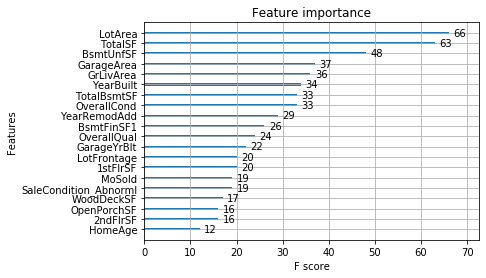

In [36]:
#feat_importances = pd.Series(best_model.feature_importances_, index=X_test_processed.columns)
#feat_importances.nlargest(20).plot(kind='barh')



plot_importance(best_model, max_num_features=20) # top 10 most important features
plt.show()

In [35]:
grid_xgb.best_params_


{'colsample_bytree': 0.8,
 'gamma': 0.03,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 2.5,
 'subsample': 0.6}